In [47]:
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from  torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler


from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2

In [48]:
is_notebook = True

In [50]:
if is_notebook:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm


In [4]:
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nf, inner_nf, input_nf=None, outermost=False, innermost=False,
                 submodule=None, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nf is None:
            input_nf = outer_nf
        downconv = nn.Conv2d(input_nf, inner_nf, kernel_size=4, 
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm= norm_layer(inner_nf)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nf)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nf * 2, outer_nf,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nf, outer_nf,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nf * 2, outer_nf,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [5]:
class UnetGenerator(nn.Module):
    def __init__(self, c_input, c_output, n_downsampling, n_filters,
                norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGenerator, self).__init__()
        unet_block = UnetSkipConnectionBlock(n_filters*8, n_filters*8, input_nf=None, submodule=None, norm_layer = norm_layer, innermost=True)
        for i in range(n_downsampling - 5):
            unet_block = UnetSkipConnectionBlock(n_filters*8, n_filters*8, input_nf=None, submodule=unet_block, norm_layer = norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(n_filters*4, n_filters*8, input_nf=None, submodule=unet_block, norm_layer = norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(n_filters*2, n_filters*4, input_nf=None, submodule=unet_block, norm_layer = norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(n_filters, n_filters*2, input_nf=None, submodule=unet_block, norm_layer = norm_layer, use_dropout=use_dropout)
        self.model = UnetSkipConnectionBlock(c_output, n_filters, input_nf=c_input, submodule=unet_block, norm_layer = norm_layer, outermost=True, use_dropout=use_dropout)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class NLayerDiscriminator(nn.Module):
    def __init__(self, c_input, n_filters, n_layers, norm_layer=nn.BatchNorm2d):
        super(NLayerDiscriminator, self).__init__()
        use_bias=False
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(c_input, n_filters, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(n_filters * nf_mult_prev, n_filters * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(n_filters * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(n_filters * nf_mult_prev, n_filters * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(n_filters * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(n_filters * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)
    
    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [7]:
class GANLoss(nn.Module):
    """Define different GAN objectives.
    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.
        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image
        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.
        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.
        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss


In [41]:
    class Pix2Pix(nn.Module):
        def __init__(self, opt):
            super(Pix2Pix, self).__init__()
            self.opt = opt
            self.gpu_ids = opt['gpu_ids']
            self.isTrain = opt['isTrain']
            self.device = torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')  # get device name: CPU or GPU

            # Generator network
            self.use_dropout = opt['use_dropout']
            self.netG = UnetGenerator(opt['c_input'], opt['c_output'], opt['n_downsampling'], opt['ng_filters'], nn.BatchNorm2d, self.use_dropout)

            # Discriminator network
            self.netD = NLayerDiscriminator(opt['c_input'] + opt['c_output'], opt['nd_filters'], opt['nd_layers'], nn.BatchNorm2d)
            self.lossGAN = GANLoss('vanilla').to(self.device)
            self.lossL1 = torch.nn.L1Loss()

            self.optimizer_G = torch.optim.Adam(self.netG.parameters(), lr=opt['lr'], betas=(opt['beta1'], 0.999))
            self.optimizer_D = torch.optim.Adam(self.netD.parameters(), lr=opt['lr'], betas=(opt['beta1'], 0.999))
            
            def lambda_rule(epoch):
                lr_l = 1.0 - max(0, epoch + opt['epoch_count'] - opt['n_epochs']) / float(opt['n_epochs_decay'] + 1)
                return lr_l
            
            self.scheduler_G = lr_scheduler.LambdaLR(self.optimizer_G, lr_lambda=lambda_rule)
            self.scheduler_D = lr_scheduler.LambdaLR(self.optimizer_D, lr_lambda=lambda_rule)

            
            
            if len(self.gpu_ids) > 0:
                assert(torch.cuda.is_available())
                self.netG.to(self.gpu_ids[0])
                self.netG = torch.nn.DataParallel(self.netG, self.gpu_ids)
                self.netD.to(self.gpu_ids[0])
                self.netD = torch.nn.DataParallel(self.netD, self.gpu_ids)
            


        def forward(self, x):
            """Run forward pass; called by both functions <optimize_parameters> and <test>."""
            x = x.to(self.device)
            return self.netG(x)  # G(A)

        def set_requires_grad(self, nets, requires_grad=False):
            """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
            Parameters:
                nets (network list)   -- a list of networks
                requires_grad (bool)  -- whether the networks require gradients or not
            """
            if not isinstance(nets, list):
                nets = [nets]
            for net in nets:
                if net is not None:
                    for param in net.parameters():
                        param.requires_grad = requires_grad
                        
        def update_learning_rate(self):
            self.scheduler_G.step()
            self.scheduler_D.step()


In [36]:
import os
def get_meta(root_dir):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths = []
    
    for entry in os.scandir(root_dir):
        if (entry.is_file()):
            paths.append(entry.path)
    return paths

In [52]:
if is_notebook:
    root_dir_A = "./data/trainA/"
    root_dir_B = "./data/trainB/"
else:
    root_dir_A = "/nobackup/sc19adpm/DeepStreetsData/trainA/"
    root_dir_B = "/nobackup/sc19adpm/DeepStreetsData/trainB/"

paths_A = get_meta(root_dir_A)
paths_B = get_meta(root_dir_B)

data = {
    'A': paths_A,
    'B': paths_B
}
data_df = pd.DataFrame(data, columns=['A', 'B'])
data_df = data_df.sample(frac=1).reset_index(drop=True)

In [25]:
data_df.head()

,A,B
0,./data/trainA/se2833_86.jpg,./data/trainB/se2833_86.jpg
1,./data/trainA/se3237_14.jpg,./data/trainB/se3237_14.jpg
2,./data/trainA/se2933_17.jpg,./data/trainB/se2933_17.jpg
3,./data/trainA/se2737_69.jpg,./data/trainB/se2737_69.jpg
4,./data/trainA/se2740_119.jpg,./data/trainB/se2740_119.jpg


In [26]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 256, 256
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs

In [27]:
#norm_mean_A, norm_std_A = compute_img_mean_std(paths_A)

In [28]:
#norm_mean_B, norm_std_B = compute_img_mean_std(paths_B)

In [29]:
from PIL import Image
import cv2
from torch.utils.data import Dataset

class Streets(Dataset):
    def __init__(self, df, transform_A, transform_B):
        self.df = df
        self.transform_A = transform_A
        self.transform_B = transform_B
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        x = Image.open(open(self.df['A'][index], 'rb')) 
        y = Image.open(open(self.df['B'][index], 'rb')) 
        
        x = self.transform_A(x)
        y = self.transform_B(y)
        return x, y 
        

In [30]:
data_transform_A = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Should we use a transform for B too? (Yes, they do)
data_transform_B = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [31]:
train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

ins_dataset_train = Streets(
    df=data_df[:train_size],
    transform_A=data_transform_A,
    transform_B=data_transform_B
)

ins_dataset_valid = Streets(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform_A=data_transform_A,
    transform_B=data_transform_B
)

ins_dataset_test = Streets(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform_A=data_transform_A,
    transform_B=data_transform_B
)

In [32]:
batch_size = 1
train_loader = DataLoader(dataset=ins_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=ins_dataset_test, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(dataset=ins_dataset_valid, batch_size=batch_size, shuffle=False)

In [33]:
def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.
    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)

In [42]:
opt = {
    'gpu_ids': [0],
    'isTrain': True,
    'use_dropout': True,
    'c_input': 3,
    'c_output': 3,
    'n_downsampling': 8,
    'nd_filters': 64,
    'ng_filters': 64,
    'nd_layers': 3,
    'lr':0.0002,
    'beta1': 0.5,
    'lambda_L1': 100,
    'n_epochs': 100,
    'n_epochs_decay': 100,
    'epoch_count': 1,
    
}
model = Pix2Pix(opt)

In [43]:
print(model)

Pix2Pix(
  (netG): DataParallel(
    (module): UnetGenerator(
      (model): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                  (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (3): UnetSkipConnectionBlock(
                    (model): Sequential(


Epoch [1/1000], Loss_D: 0.0002,  Loss_G: 24.3251


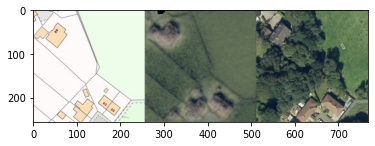

KeyboardInterrupt: 

In [44]:
# Train the model
train_loss_list = []
train_acc_list = []

num_epochs = 1000
for epoch in range(num_epochs):
    loss_D_list = []
    loss_G_list = []
    acc_list = []
    for i, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(model.device)
        targets = targets.to(model.device)
        # Run the forward pass
        outputs = model(inputs)

        # update D
        model.set_requires_grad(model.netD, True)  # enable backprop for D
        model.optimizer_D.zero_grad()     # set D's gradients to zero
        inputs_D_fake = torch.cat((inputs, outputs), 1)  # we use conditional GANs; we need to feed both input and output to the discriminator

        # Fake; stop backprop to the generator by detaching fake_B
        
        outputs_D_fake = model.netD(inputs_D_fake.detach())

        loss_D_fake = model.lossGAN(outputs_D_fake, False)
        # Real
        inputs_D_real = torch.cat((inputs, targets), 1)
        outputs_D_real = model.netD(inputs_D_real)
        loss_D_real = model.lossGAN(outputs_D_real, True)
        # combine loss and calculate gradients
        loss_D = (loss_D_fake + loss_D_real) * 0.5
        loss_D_list.append(loss_D.item())
        loss_D.backward()
        model.optimizer_D.step()          # update D's weights

        
        # update G
        model.set_requires_grad(model.netD, False)  # D requires no gradients when optimizing G
        model.optimizer_G.zero_grad()        # set G's gradients to zero
        
        inputs_D_fake = torch.cat((inputs, targets), 1)
        outputs_D_fake = model.netD(inputs_D_fake)
        loss_G_GAN = model.lossGAN(outputs_D_fake, True)
        # Second, G(A) = B
        loss_G_L1 = model.lossL1(outputs, targets) * model.opt['lambda_L1']        # combine loss and calculate gradients
        loss_G = loss_G_GAN + loss_G_L1
        loss_G_list.append(loss_G.item())
        loss_G.backward()
        model.optimizer_G.step()             # udpate G's weights
        
        
        # Track the accuracy
        
    print('Epoch [{}/{}], Loss_D: {:.4f},  Loss_G: {:.4f}'
              .format(epoch + 1, num_epochs, loss_D_list[i],  loss_G_list[i]))
    if epoch % 10 == 0:
        img_A = Image.open(paths_A[600])
        img = data_transform_A(img_A)
        img = torch.from_numpy(np.expand_dims(img, axis=0))
        img = img.to(model.device)
        out = model(img)
        img_B_fake = tensor2im(out)
        img_B_real = Image.open(paths_B[600])
        img = np.concatenate((img_A, img_B_fake, img_B_real), axis=1) 
        plt.imshow(img)
        plt.show()
        plt.imsave('results/{}.jpg'.format(epoch), img)